In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss

import requests
from urllib.parse import urlencode
import json

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

# Цель исследования
При помощи A/B–тестирования оценить, выгодно ли внедрять новую механику оплаты услуг на сайте.  
Во время исследования участники были отнесены к целевой (новая механика оплаты) или контрольной (исходная механика оплаты) группам.

### Задачи исследования:
- Определить метрики, которые будут рассмотрены в ходе анализа, и объяснить выбор метрик.
- Выявить различия в показателях (если они имеются) и объяснить их.
- Определить, являются ли различия статистически значимыми.
- Определить, выгодно ли запускать новую механику на всех пользователей.
- Задать функции, которые позволят автоматически подгружать дополнительную информацию о пользователях, переданную в файле `groups_add.csv` и визуализировать результаты эксперимента.

### Характеристика отчета:

- Аналитическое исследование выполнено на языке программирования Python.  
- Файл представляет собой законченный отчёт с выводами, сделанными в ходе исследования.

In [2]:
# файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
active_st = pd.read_csv('./Проект_2_active_studs.csv')
active_st.head(2)

,student_id
0,581585
1,5723133


In [3]:
# файл с информацией об оплатах пользователей в дни проведения эксперимента. 
checks = pd.read_csv('./Проект_2_checks.csv', sep=';')
checks.head(2)

,student_id,rev
0,1627,990.0
1,3185,690.0


In [4]:
# файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль,B – целевая группа) 
groups = pd.read_csv('./Проект_2_groups.csv', sep=';')
groups.head(2)

,id,grp
0,1489,B
1,1627,A


## Предварительный анализ (EDA)
Изучим имеющиеся данные:
- Оценим число уникальных пользователей в каждой из групп
- Оценим число наблюдений (оплат и посещений) в каждой из групп и число наблюдений для уникальных пользователей
- Изучим характер распределения в датасете с оплатами

In [5]:
print("Число строк в файле groups: ", groups.shape[0])
print("Число уникальных пользователей: ", groups.id.nunique())

Число строк в файле groups:  74484
Число уникальных пользователей:  74484


In [6]:
groups.grp.value_counts() # число id в каждой из групп (в целевой группе больше)

B    59813
A    14671
Name: grp, dtype: int64

Рассмотрим файлы с информацией о посещениях и об оплатах

In [7]:
print("Число строк в файле checks: ", checks.shape[0])
print("Число уникальных пользователей: ", checks.student_id.nunique())

Число строк в файле checks:  541
Число уникальных пользователей:  541


In [8]:
print("Число строк в файле active_st: ", active_st.shape[0])
print("Число уникальных пользователей: ", active_st.student_id.nunique())

Число строк в файле active_st:  8341
Число уникальных пользователей:  8341


Изучим характер распределения размера выручки на пользователя и основные описательные статистики этого распределния

In [9]:
checks.rev.describe()

count     541.000000
mean     1059.752317
std       762.712359
min       199.000000
25%       290.000000
50%       840.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

<Axes: xlabel='rev', ylabel='Count'>

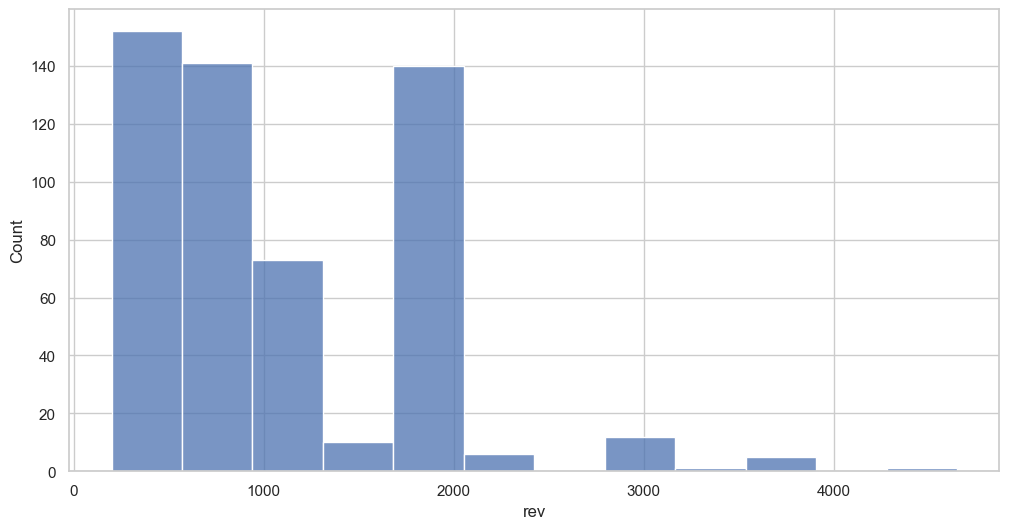

In [10]:
sns.histplot(checks.rev) #видим, что распределние бимодальное - необходимо изучить, с чем это связано

#### Объединим дф с информацей о разбиении на группы, посещениях и оплатах - составим общий дф для оценки результатов эксперимента.  
Вначале объединяем дф с информацией о разбиении на группы и дф с активными пользователями в период проведения эксперимента: здесь используем inner join, т.к. нам для анализа понадобится информация только о пользователях, которые были активны в момент эксперимента и которые отнесены к какой-либо из двух групп. Также не все активные во время эксперимента пользователи были отнесены к какой-либо из двух групп (мы знаем, что нам должны прислать дополнительный файл с информацией о разбиении на группы части пользователей).  
  
Затем к полученному дф присоединяем информацию об оплатах - в этом случае используем left join, т.к. не все активные во время эксперимента пользователи могли совершить оплату. Удаляем колонку, дублирующую информацию об id.

In [11]:
groups_active = groups.merge(active_st, how = 'inner', left_on = 'id', right_on = 'student_id')\
                            .merge(checks, how = 'left', on = 'student_id')\
                            .drop('id', axis=1)
groups_active.head(2)

,grp,student_id,rev
0,A,1627,990.0
1,B,2085,NaN


In [12]:
print("Проводим A/B тест на основании информации о ", groups_active.student_id.nunique(), " пользователях")
print("Разбивка по группам:")
print("А - ", groups_active.grp.value_counts().A, "пользователей")
print("B - ", groups_active.grp.value_counts().B, "пользователей")

Проводим A/B тест на основании информации о  8328  пользователях
Разбивка по группам:
А -  1535 пользователей
B -  6793 пользователей


Мы видим, что в тестовой группе в несколько раз больше пользователей, чем в контрольной. Возможно, система сплитования работает некорректно

In [13]:
# добавляем колонку, где указано, совершил ли пользователь покупку
groups_active['purchases'] = groups_active.rev.apply(lambda x: 'no_purchase' if pd.isna(x) else 'purchase')
groups_active.head(2)

,grp,student_id,rev,purchases
0,A,1627,990.0,purchase
1,B,2085,NaN,no_purchase


## Метрика 1: Конверсия в покупку

Изменение механизма оплаты могло привести к увеличению числа платящих пользователей, т.е. к увеличению конверсии. Оценим соотношение активных и платящих пользователей в тестовой и контрольной группах и посчитаем показатель конверсии

In [14]:
pd.crosstab(groups_active.grp, groups_active.purchases)

purchases,no_purchase,purchase
grp,,
A,1457,78
B,6480,313


In [15]:
print("Конверсия в контрольной группе: ", \
      round(groups_active.query('grp == "A" and purchases == "purchase"').student_id.nunique()/\
      groups_active.query('grp == "A"').student_id.nunique(), 3))

print("Конверсия в тестовой группе: ", \
round(groups_active.query('grp == "B" and purchases == "purchase"').student_id.nunique()/\
      groups_active.query('grp == "B"').student_id.nunique(), 3))

Конверсия в контрольной группе:  0.051
Конверсия в тестовой группе:  0.046


Необходимо проверить гипотезу при помощи статистического теста. Поскольку мы работаем с категориальными переменными - для проверки гипотезы о том, что __конверсия не изменилась (Н0)__ используем критерий хи-квадрат. __Н1 - конверсия в группах статистически значимо различается__

In [16]:
stat, p, dof, expected = ss.chi2_contingency(pd.crosstab(groups_active.grp, groups_active.purchases))

In [17]:
stat, p

(0.526607176998989, 0.46803677583199144)

Мы получили p-value сильно больше 0,05 - это говорит о том, что мы __не можем отклонить нулевую гиптезу (Н0)__ о том, что конверсия в тестовой и контрольной группах не различается. Различия значений конверсии, полученные в результате эксперимента с изменением механики оплаты, считаем несущественными. __Н1 отклоняем__

## Метрики 2 и 3: ARPU - средняя выручка на пользователя и ARPPU - выручка на платящего пользователя
Изменение механики системы оплаты могло привести к изменению средней выручки на пользователя. Если мы наблюдаем увеличение ARPU или ARPPU в тестовой группе - значит имеет смысл внедрить новую механику. Оценим эти метрики и проверим, наблюдаются ли статистически значимые различия.  
  
Изучим распределение выручки на пользователя в двух группах. Для этого построим график.  
  
На графике явно заметен пик в области значения выручки 2000, который наблюдается только в тестовой группе и отсутствует в контрольной. Если бы я могла обсудить этот момент с командой, которая прооводит эксперимет - я бы попыталась узнать, связан ли этот пик как раз с изменением механики оплаты (например, могли внедрить автоматическое списание при продлении подписки - таким образом в тестовой группе резко увеличилось число пользователей, которые во время проведения эксперимента внесли одинаковую сумму денег для продления подписки). Возможно, на результаты эксперимента по оценке эффективности новой механики оплаты оказало влияние какое-то другое событие, с этим экспериментом не связанное - возможно промо какого-либо товара или что-то еще. В таком случае, эти выбросы следовало бы исключить или проводить эксперимент больше, чтобы нивелировать это воздействие.  
__Будем считать выброс результатом нашего эксперимента, т.е. не будем исключать эти значения, а оценим их влиение на ARPU и ARPPU__

<Axes: xlabel='rev', ylabel='Count'>

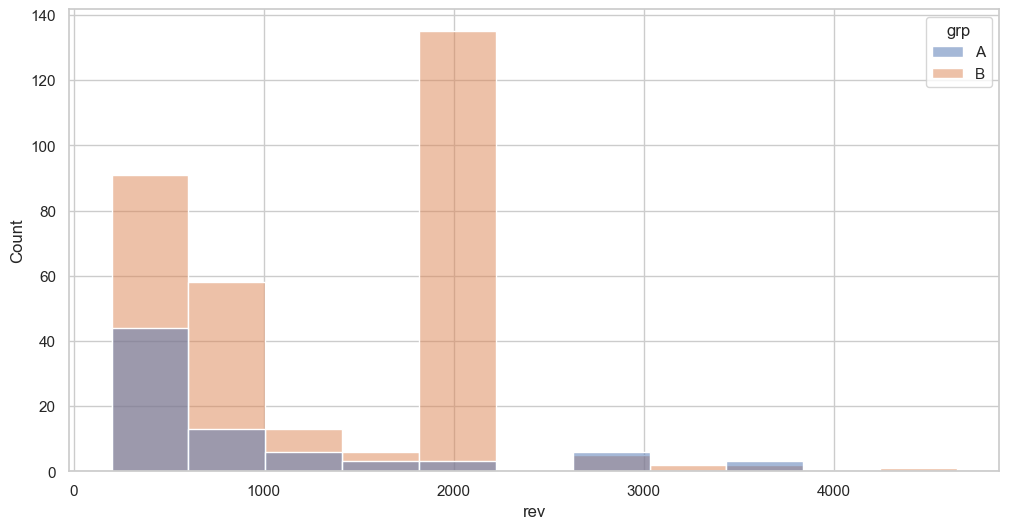

In [18]:
sns.histplot(data=groups_active, x="rev", hue="grp")

In [19]:
groups_active['rev'] = groups_active.rev.fillna(0) # заменим пропущенные значения в колонке с выручкой на 0

In [20]:
print("ARPU в контрольной группе: ",round(groups_active.query('grp == "A"').rev.mean(), 3))
print("ARPU в тестовой группе: ",round(groups_active.query('grp == "B"').rev.mean(), 3))

ARPU в контрольной группе:  47.44
ARPU в тестовой группе:  57.865


In [21]:
print("ARPPU в контрольной группе: ",round(groups_active.query('grp == "A" and purchases == "purchase"').rev.median(), 3))
print("ARPPU в тестовой группе: ",round(groups_active.query('grp == "B" and purchases == "purchase"').rev.median(), 3))

ARPPU в контрольной группе:  585.0
ARPPU в тестовой группе:  1140.0


Расчет показывает, что в тестовой группе увеличились ARPU и ARPPU. Проведем статистический тест для оценки статистической значимости этих различий.  
  
По графику видно, что распределения в обоих группах не нормальные, поэтому не станем применять критерий Стьюдента. Критерий Манна-Уитни не будем применять из-за сложной интерспретируемости для бизнеса. В этом случае для статистического анализа подойдет бутстреп: сравним разницы средних в выручке среди активных пользователей (ARPU) и медиан - среди платящих пользователей (ARPPU).   

**Н0** - значения в тестовой и контрольной группах не различаются, **Н1** - значения в тестовой и контрольной группах статистически значимо различаются.

In [22]:
ss.bootstrap([groups_active.query('grp == "A"').rev, 
             groups_active.query('grp == "B"').rev], 
             statistic=lambda x, y: np.mean(x) - np.mean(y))

BootstrapResult(confidence_interval=ConfidenceInterval(low=-24.810781189013642, high=8.313444837643306), bootstrap_distribution=array([-13.93732699, -14.86105808, -30.18906427, ..., -27.25907247,
        -5.90471115, -13.63976376]), standard_error=8.261985566380472)

Анализ показал отсутствие значимых различий в ARPU в тестовой и контрольной группах (значение 0 входит в доверительный интервал, мы не можем отклонить нулевую гипотезу о том, что средние в тестовой и контрольной группах значимо не различаются). ***Внедрение новой механики оплаты не оказало существенного воздействия на ARPU***

In [23]:
ss.bootstrap([groups_active.query('grp == "A" and purchases == "purchase"').rev, 
             groups_active.query('grp == "B" and purchases == "purchase"').rev], 
             statistic=lambda x, y: np.median(x) - np.median(y))

BootstrapResult(confidence_interval=ConfidenceInterval(low=-1315.0, high=-300.0), bootstrap_distribution=array([-1320. ,  -515.5, -1260. , ...,  -950. ,  -940. ,  -940. ]), standard_error=287.67045696160164)

Бутстреп-анализ показывает наличие значимых различий в ARPPU в тестовой и контрольной группах (0 не входит в доверительный интервал, поэтому мы отклоняем нулевую гипотезу о том, что значимых различий нет). ***Внедрение новой механики оплаты оказывает влияние на ARPPU в тестовой группе.***

__В ходе эксперимента мы наблюдаем значительный, статистически значимый рост ARPPU в тестовой группе, что говорит о том, что запуск новой механики оплаты был бы выгоден для нас.__ Однако, для того, чтобы быть более уверенной в этом выводе, я бы обсудила с командой сам подход к проведению эксперимента (система сплитования делить пользователей не в равной пропорции, в данных наблюдается выброс - необходимо понять, вызван ли он особенностями эксперимента или это внешнее влияние)  
  
__Статистически значимых различий конверсии в покупку и ARPU  в тестовой и контрольной группах выявлено не было__ - внедрение новой механики оплаты не оказало на эти метрики значимого влияния

## Задача: автоматическое внесение данных о разбивке пользователей на группы из дополнительного файла
Нам прислали дополнительный файл с информацией о разбиении пользователей на группы. Добавим информацию об эих пользователях в наш сводный файл и повторим расчет метрик.   
Зададим функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv и на основании дополнительных параметров пересчитывать метрики.

In [24]:
def update(groups, active_students, checks):
    public_key_groups_add = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ' #загружаем файл с яндекс диска
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url_groups_add = base_url + urlencode(dict(public_key=public_key_groups_add))
    response_groups_add = requests.get(final_url_groups_add)
    download_url_groups_add = json.loads(response_groups_add.text)['href']
    groups_add = pd.read_csv(download_url_groups_add, sep=',') #открываем файл csv
    groups_all = pd.concat([groups_add, groups]) #объединяем файлы с информацией о группах
    df = groups_all.merge(active_students, how='inner', left_on = 'id', right_on = 'student_id')\
                    .merge(checks, how='left',on = 'student_id').drop('id', axis=1) #объедимяем с информацией об активности и оплатах
    df['purchases'] = df.rev.apply(lambda x: 'no_purchase' if pd.isna(x) else 'purchase')
    df = df.fillna(0)
    conversion = pd.crosstab(df.grp, df.purchases)
    cr = pd.DataFrame(conversion['purchase']/(conversion['purchase']+conversion['no_purchase'])).reset_index() \
        .rename(columns={0: 'CR'})
    arppu = pd.DataFrame({'grp': ['A', 'B'],
                          'ARPPU': [
                              df.query('grp == "A" and purchases == "purchase"').rev.mean(),
                              df.query('grp == "B" and purchases == "purchase"').rev.mean()]}) #ARPPU
    arpu = pd.DataFrame({'grp': ['A', 'B'],
                          'ARPU': [
                              df.query('grp == "A"').rev.mean(),
                              df.query('grp == "B"').rev.mean()]}) #ARPU
    return {'CR': cr,
            'arppu': arppu,
            'arpu': arpu}

In [25]:
update_info = update(groups, active_st, checks) #обновленные значения метрик

In [26]:
update_info['CR'] #пример пересчета метрик: конверсия по группам после обновления информации составе групп

,grp,CR
0,A,0.050715
1,B,0.046156


## Визуализация метрик
Зададим функцию для визуализации метрик, рассматриваемых в ходе исследования.

In [27]:
def graf(update_info):    
    plt.figure(figsize=(20, 9))
    plt.subplot(1, 3, 1)
    bar = sns.barplot(x='grp', y='ARPPU', data=update_info['arppu'])
    bar.axes.set_title('ARPPU') 
    plt.subplot(1, 3, 2)
    bar = sns.barplot(x='grp', y='ARPU', data=update_info['arpu'])
    bar.axes.set_title('ARPU')
    plt.subplot(1, 3, 3)
    bar = sns.barplot(x='grp', y='CR', data=update_info['CR'])
    bar.axes.set_title('CR')

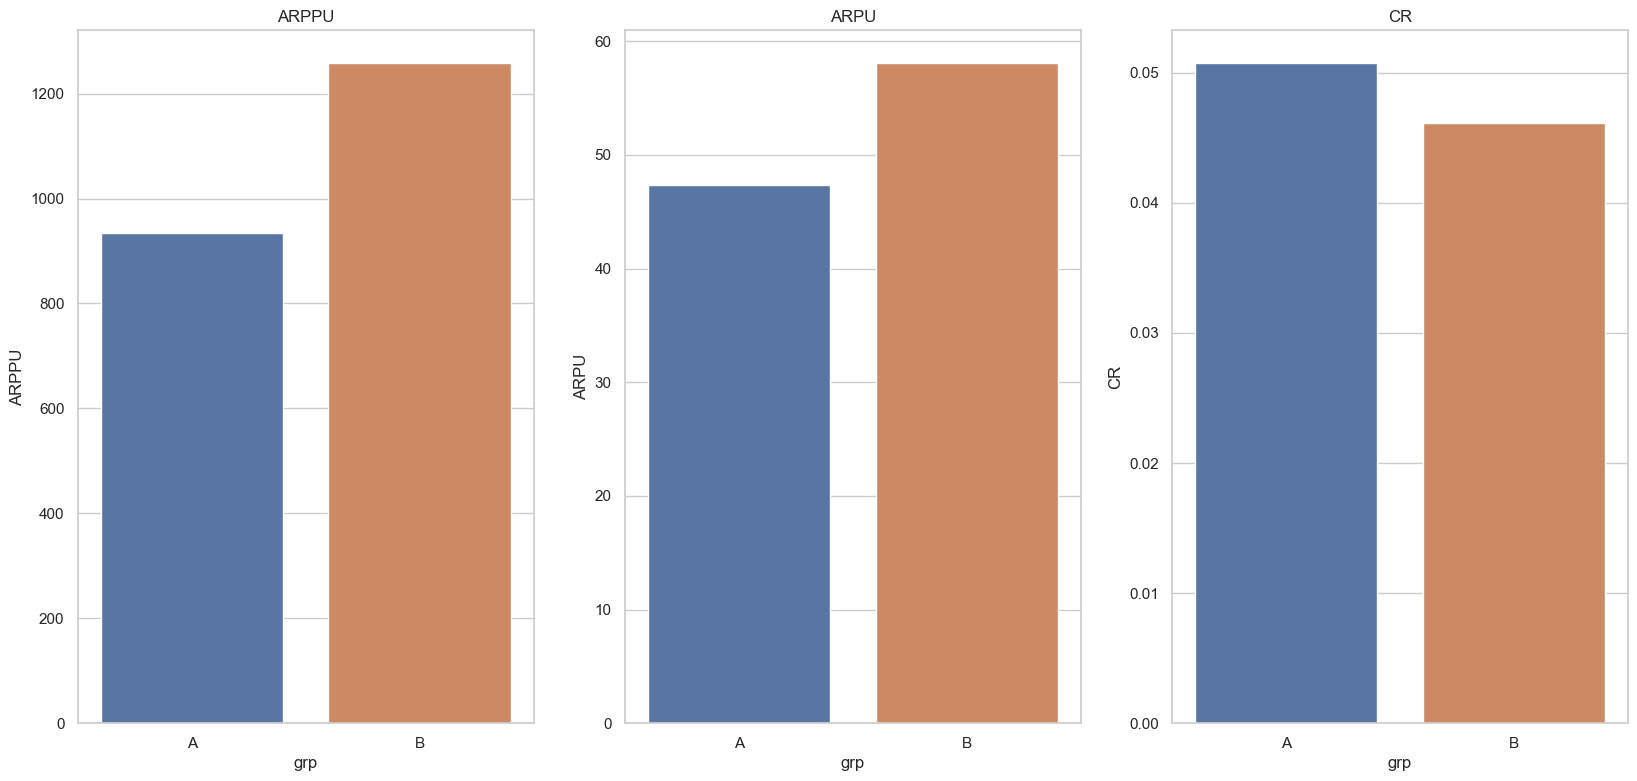

In [28]:
graf(update_info)